In [1]:
import os
import json
import pandas as pd
pd.set_option('display.max_colwidth', 1000)

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns

In [3]:
data_dir = "./data"

In [4]:
files = os.listdir(data_dir)

In [5]:
files

['tpch.sql', 'slow_log.json', 'general_log.json']

In [6]:
df_general_logs = pd.read_json(data_dir+'/general_log.json')

In [7]:
df_general_logs.head()

,event_time,user_host,thread_id,server_id,command_type,argument
0,2021-01-14 15:19:54.549896,guest[guest] @ [185.9.209.177],67,97408076,Query,/* ApplicationName=DataGrip 2020.2.3 */ select * from mysql.general_log where event_time > '2021-01-14 11:20:54.451611' order by event_time desc
1,2021-01-14 15:19:54.489750,guest[guest] @ [185.9.209.177],67,97408076,Query,/* ApplicationName=DataGrip 2020.2.3 */ SET net_write_timeout=600
2,2021-01-14 15:19:54.430215,guest[guest] @ [185.9.209.177],67,97408076,Query,SHOW WARNINGS
3,2021-01-14 15:19:54.369984,guest[guest] @ [185.9.209.177],67,97408076,Query,SHOW WARNINGS
4,2021-01-14 15:19:54.310359,guest[guest] @ [185.9.209.177],67,97408076,Query,/* ApplicationName=DataGrip 2020.2.3 */ select database()


In [8]:
df_slow_logs = pd.read_json(data_dir+'/slow_log.json', convert_dates=False)

In [9]:
df_slow_logs.head()

,start_time,user_host,query_time,lock_time,rows_sent,rows_examined,db,last_insert_id,insert_id,server_id,sql_text,thread_id
0,2021-01-14 15:11:51.815988,guest[guest] @ [185.9.209.177],00:00:00.000093,00:00:00,0,0,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ SET net_write_timeout=600,67
1,2021-01-14 15:11:51.749969,guest[guest] @ [185.9.209.177],00:00:00.000055,00:00:00,0,0,tpch,0,0,97408076,SHOW WARNINGS,67
2,2021-01-14 15:11:51.687122,guest[guest] @ [185.9.209.177],00:00:00.000076,00:00:00,0,0,tpch,0,0,97408076,SHOW WARNINGS,67
3,2021-01-14 15:11:51.623647,guest[guest] @ [185.9.209.177],00:00:00.000138,00:00:00,1,1,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ select database(),67
4,2021-01-14 15:11:51.562513,guest[guest] @ [185.9.209.177],00:00:00.000090,00:00:00,0,0,tpch,0,0,97408076,/* ApplicationName=DataGrip 2020.2.3 */ SET SQL_SELECT_LIMIT=DEFAULT,67


# SLOW LOG - PREPROCESSING

### rows_sent

In [10]:
len(set(df_slow_logs['rows_sent']))

1462

In [11]:
df_slow_logs[df_slow_logs['rows_sent'].isna()]

,start_time,user_host,query_time,lock_time,rows_sent,rows_examined,db,last_insert_id,insert_id,server_id,sql_text,thread_id


### rows_examined

In [12]:
len(set(df_slow_logs['rows_examined']))

2342

In [13]:
df_slow_logs[df_slow_logs['rows_examined'].isna()]

,start_time,user_host,query_time,lock_time,rows_sent,rows_examined,db,last_insert_id,insert_id,server_id,sql_text,thread_id


## check if possible to remove some columns if they are not significant

## id columns

In [14]:
len(set(df_slow_logs['last_insert_id']))

1

In [15]:
del df_slow_logs['last_insert_id']

In [16]:
len(set(df_slow_logs['insert_id']))

1

In [17]:
del df_slow_logs['insert_id']

In [18]:
len(set(df_slow_logs['server_id']))

1

In [19]:
del df_slow_logs['server_id']

In [20]:
len(set(df_slow_logs['thread_id']))

52

### start_time

In [21]:
len(set(df_slow_logs['start_time']))

15688

In [22]:
# the same length of the df, it may be not necessary
del df_slow_logs['start_time']

### db

In [23]:
len(set(df_slow_logs['db']))

2

In [24]:
set(df_slow_logs['db'])

{'', 'tpch'}

In [25]:
len(df_slow_logs[(df_slow_logs['db'] == '')])

9248

In [26]:
# assign "NO-DB" label to records with empty db value
df_slow_logs.loc[(df_slow_logs['db'] == ''), 'db'] = "NO-DB"

### user_host

In [27]:
set(df_slow_logs['user_host'])

{'guest[guest] @  [172.31.36.183]',
 'guest[guest] @  [185.9.209.177]',
 'rdsadmin[rdsadmin] @ localhost [127.0.0.1]',
 'rdsadmin[rdsadmin] @ localhost []'}

In [28]:
def get_category_user_host(user_host):
    if(user_host == 'guest[guest] @  [172.31.36.183]'):
        return 'G-172'
    if(user_host == 'guest[guest] @  [185.9.209.177]'):
        return 'G-185'
    if(user_host == 'rdsadmin[rdsadmin] @ localhost [127.0.0.1]'):
        return 'R-127'
    if(user_host == 'rdsadmin[rdsadmin] @ localhost []'):
        return 'R-L'
    print(user_host)
    print("ERROR category user")

In [29]:
df_slow_logs['user_host'] = df_slow_logs['user_host'].apply(lambda x: get_category_user_host(x))

## check max for lock and query time

In [30]:
df_slow_logs['lock_time'].max()

'00:00:00.071033'

In [31]:
df_slow_logs['query_time'].max()

'00:00:11.073425'

## depending on the max we can apply different formatting 

In [32]:
def get_numerical_value_lock_time(lock_time):
    '''
    Convert the string to a number by getting the digits after the "."
    '''
    if len(lock_time.split(".")) > 1:
        return int(lock_time.split(".")[1])
    else:
        if(lock_time == "00:00:00"):
            return 0
        else:
            print(lock_time)

In [33]:
df_slow_logs['lock_time'] = df_slow_logs['lock_time'].apply(lambda x: get_numerical_value_lock_time(x))

In [34]:
df_slow_logs['lock_time'].min()

0

In [35]:
df_slow_logs['lock_time'].max()

71033

In [36]:
def get_numerical_value_query_time(query_time):
    '''
    Convert the string to a number by getting the digits after the last ":" and removing "."
    '''
    if(len(query_time.split(":")) >= 3):
        if "." in query_time:
            return int(query_time.split(":")[2].replace(".",""))
        else:
            if(lock_time == "00:00:00"):
                return 0
            else:
                print(query_time)
    else:
        print(query_time)

In [37]:
df_slow_logs['query_time'] = df_slow_logs['query_time'].apply(lambda x: get_numerical_value_query_time(x))

In [38]:
df_slow_logs['query_time'].min()

7

In [39]:
df_slow_logs['query_time'].max()

11073425

#### see df_slow_logs after first preprocessing steps

In [40]:
df_slow_logs

,user_host,query_time,lock_time,rows_sent,rows_examined,db,sql_text,thread_id
0,G-185,93,0,0,0,tpch,/* ApplicationName=DataGrip 2020.2.3 */ SET net_write_timeout=600,67
1,G-185,55,0,0,0,tpch,SHOW WARNINGS,67
2,G-185,76,0,0,0,tpch,SHOW WARNINGS,67
3,G-185,138,0,1,1,tpch,/* ApplicationName=DataGrip 2020.2.3 */ select database(),67
4,G-185,90,0,0,0,tpch,/* ApplicationName=DataGrip 2020.2.3 */ SET SQL_SELECT_LIMIT=DEFAULT,67
...,...,...,...,...,...,...,...,...
15683,R-127,74,0,1,1,NO-DB,SELECT 1,9
15684,R-127,147,0,1,1,NO-DB,SELECT 1,9
15685,G-185,91,0,1,1,tpch,SELECT @@session.transaction_isolation,14
15686,G-185,102,0,0,0,tpch,SHOW WARNINGS,14


# SQL QUERIES ANALYSIS

In [41]:
df_slow_logs["sql_text"] = df_slow_logs["sql_text"].str.lower()
df_slow_logs["sql_text"] = df_slow_logs["sql_text"].str.replace('\n\t',' ')
df_slow_logs["sql_text"] = df_slow_logs["sql_text"].str.replace('\n',' ')
df_slow_logs["sql_text"] = df_slow_logs["sql_text"].str.replace('\t',' ')

In [42]:
def get_mean_param_time_slow_logs(query,param):
    df = df_slow_logs[df_slow_logs["sql_text"] == query]
    return sum(df[param])/len(df[param])

### group records by counting their occurrence

In [43]:
df_slow_logs_grouped = pd.DataFrame(df_slow_logs["sql_text"].value_counts())
df_slow_logs_grouped["query"] = df_slow_logs_grouped.index
df_slow_logs_grouped["label_query"] = df_slow_logs_grouped["query"].str[:50]

In [44]:
df_slow_logs_grouped["avg_query_time"] = df_slow_logs_grouped["query"].apply(lambda x: get_mean_param_time_slow_logs(x,"query_time"))
df_slow_logs_grouped["avg_lock_time"] = df_slow_logs_grouped["query"].apply(lambda x: get_mean_param_time_slow_logs(x,"lock_time"))
df_slow_logs_grouped["count_query"] = df_slow_logs_grouped["sql_text"]

In [45]:
df_slow_logs_grouped = df_slow_logs_grouped.reset_index()

In [46]:
del df_slow_logs_grouped['sql_text']
del df_slow_logs_grouped['index']

# 15 most frequent queries

In [47]:
df_15_most_freq = df_slow_logs_grouped.sort_values("count_query",ascending=False)[0:15]

In [48]:
df_15_most_freq

,query,label_query,avg_query_time,avg_lock_time,count_query
0,select 1,select 1,1.009647e+03,0.000000,5413
1,select count(*) from information_schema.tables where table_schema = 'mysql' and table_name = 'rds_heartbeat2',select count(*) from information_schema.tables whe,1.258463e+03,621.280992,968
2,select value from mysql.rds_heartbeat2,select value from mysql.rds_heartbeat2,5.156937e+02,55.190476,924
3,select @@global.read_only,select @@global.read_only,5.850866e+02,0.000000,924
4,"select count(*) from mysql.rds_replication_status where master_host is not null and master_port is not null group by action_timestamp,called_by_user,action,mysql_version,master_host,master_port order by action_timestamp limit 1",select count(*) from mysql.rds_replication_status,6.677061e+03,815.047619,231
5,"select count(*) from mysql.rds_history where action = 'disable set master' group by action_timestamp,called_by_user,action,mysql_version,master_host,master_port,master_user,master_log_file ,master_log_pos,master_ssl order by action_timestamp limit 1",select count(*) from mysql.rds_history where actio,5.881264e+03,1049.649351,231
6,select @@session.transaction_read_only,select @@session.transaction_read_only,2.939791e+02,0.000000,191
7,quit,quit,1.304255e+01,0.000000,47
8,flush logs,flush logs,2.548261e+04,0.000000,46
9,show global variables like 'mysql_cipher_stats_flush_period_in_seconds',show global variables like 'mysql_cipher_stats_flu,3.212220e+04,1505.913043,46


Text(0, 0.5, 'Average execution time')

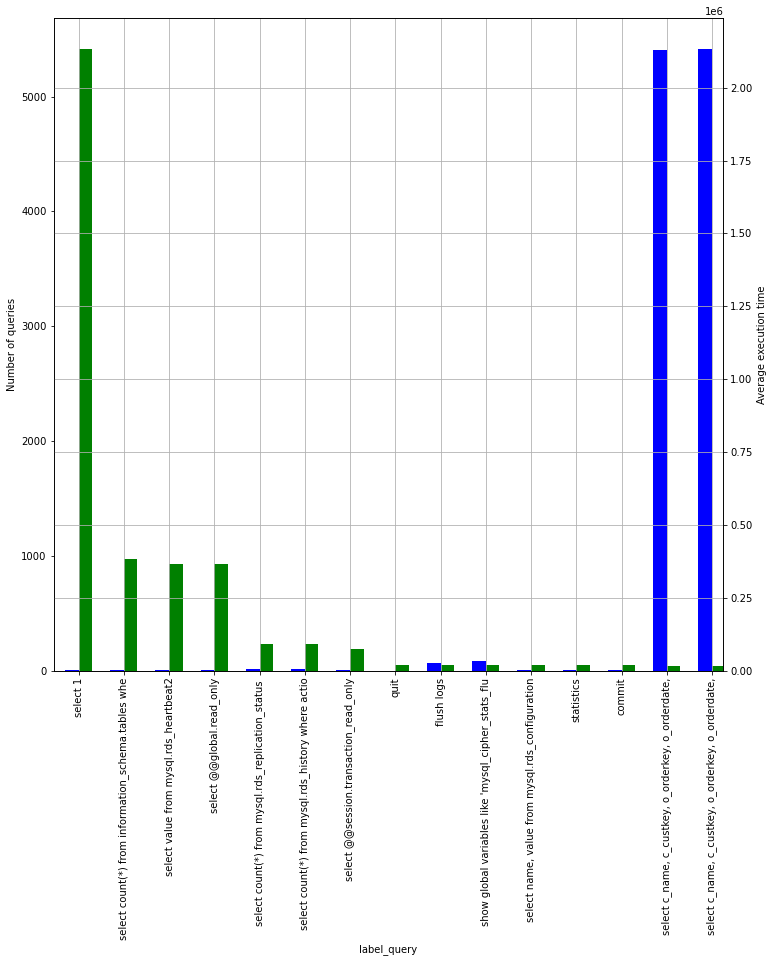

In [49]:
df = df_15_most_freq.set_index('label_query')

fig = plt.figure(figsize=(12,12)) # Create matplotlib figure

ax = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax.twinx() # Create another axes that shares the same x-axis as a
width = .3

df.count_query.plot(kind='bar',color='green',ax=ax,width=width, position=0)
df.avg_query_time.plot(kind='bar',color='blue', ax=ax2,width = width,position=1)

ax.grid(None, axis='x')
ax2.grid(None)

ax.set_ylabel('Number of queries')
ax2.set_ylabel('Average execution time')

### Plot comment: we can see in green the 15 most frequent queries and in blue their average execution time. We can already see how the most frequent queries, at least the ones among the top 10, have a much faster execution time compared with the more complex ones

# Distribution of execution time

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcad4958be0>]],
      dtype=object)

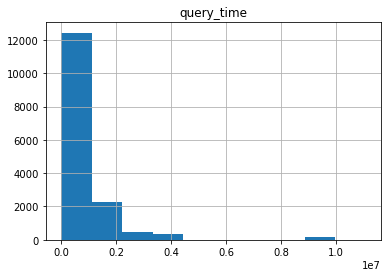

In [50]:
df_slow_logs.hist('query_time')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcad48dde50>]],
      dtype=object)

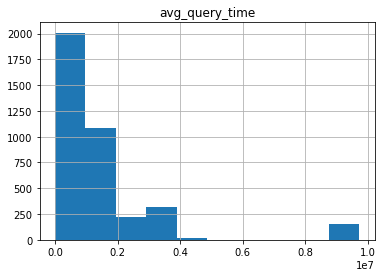

In [51]:
df_slow_logs_grouped.hist('avg_query_time')

## considering that "SELECT 1" is almost 1/3 of the queries and its impact in the speed it's not so relevat we may consider filtering those values

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcad48a5be0>]],
      dtype=object)

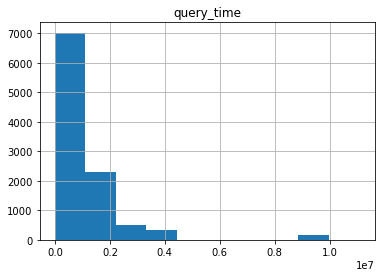

In [52]:
df_slow_logs[df_slow_logs['sql_text'] != 'select 1'].hist('query_time')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcad486ca30>]],
      dtype=object)

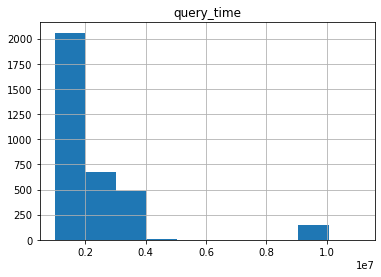

In [53]:
df_slow_logs[df_slow_logs['query_time'] > 1000000].hist('query_time')

### we can see how the majority of the slow queries are in the range between 0.1e7 and 0.4e7, while there is a small group which has a much slower execution time

In [54]:
df_slow_logs[df_slow_logs['query_time'] > 5000000]

,user_host,query_time,lock_time,rows_sent,rows_examined,db,sql_text,thread_id
515,G-185,11073425,98,77212,154424,tpch,/* applicationname=datagrip 2020.2.3 */ select * from mysql.slow_log order by start_time desc,63
2002,G-172,9513722,145,4,4423667,tpch,"-- using 1164972402 as a seed to the rng select l_returnflag, l_linestatus, sum(l_quantity) as sum_qty, sum(l_extendedprice) as sum_base_price, sum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge, avg(l_quantity) as avg_qty, avg(l_extendedprice) as avg_price, avg(l_discount) as avg_disc, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '60' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",40
2038,G-172,9528016,157,4,4423667,tpch,"-- using 377385426 as a seed to the rng select l_returnflag, l_linestatus, sum(l_quantity) as sum_qty, sum(l_extendedprice) as sum_base_price, sum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge, avg(l_quantity) as avg_qty, avg(l_extendedprice) as avg_price, avg(l_discount) as avg_disc, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '73' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",40
2077,G-172,9365976,158,4,4423667,tpch,"-- using 73836279 as a seed to the rng select l_returnflag, l_linestatus, sum(l_quantity) as sum_qty, sum(l_extendedprice) as sum_base_price, sum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge, avg(l_quantity) as avg_qty, avg(l_extendedprice) as avg_price, avg(l_discount) as avg_disc, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '110' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",40
2096,G-172,9537546,154,4,4423667,tpch,"-- using 820403100 as a seed to the rng select l_returnflag, l_linestatus, sum(l_quantity) as sum_qty, sum(l_extendedprice) as sum_base_price, sum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge, avg(l_quantity) as avg_qty, avg(l_extendedprice) as avg_price, avg(l_discount) as avg_disc, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '69' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",40
...,...,...,...,...,...,...,...,...
8228,G-172,9318512,173,4,4423667,tpch,"-- using 443017674 as a seed to the rng select l_returnflag, l_linestatus, sum(l_quantity) as sum_qty, sum(l_extendedprice) as sum_base_price, sum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge, avg(l_quantity) as avg_qty, avg(l_extendedprice) as avg_price, avg(l_discount) as avg_disc, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '117' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",40
8265,G-172,9527047,147,4,4423667,tpch,"-- using 196896744 as a seed to the rng select l_returnflag, l_linestatus, sum(l_quantity) as sum_qty, sum(l_extendedprice) as sum_base_price, sum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge, avg(l_quantity) as avg_qty, avg(l_extendedprice) as avg_price, avg(l_discount) as avg_disc, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '72' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",40
8299,G-172,9421284,152,4,4423667,tpch,"-- using 344569302 as a seed to the rng select l_returnflag, l_linestatus, sum(l_quantity) as sum_qty, sum(l_extendedprice) as sum_base_price, sum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_c

# they all seem involving table lineitem

# We are going to consider now the type of operation made in SQL and see how are they distributed according to sql execution time

In [55]:
#remove duplicates and keep the worse case in execution time
df_slow_logs_filtered = df_slow_logs.groupby('sql_text', group_keys=False).apply(lambda x: x.loc[x.query_time.idxmax()])

In [56]:
del df_slow_logs_filtered['sql_text']
df_slow_logs_filtered = df_slow_logs_filtered.reset_index()

In [57]:
sql_operations = ['select', 'insert', 'update', 'where', 'join', 'order', 'group', 'union', 'count', 'avg', 'sum', 'show', 'set', 'ping', 'quit', 'purge', 'flush', 'statistics', 'commit', 'use']

In [58]:
def set_no_op(x):
    has_op = True
    for o in sql_operations:
        if(x[o] > 0):
            has_op = False
    return has_op

In [59]:
df_slow_logs_filtered['no-op'] = True
for op in sql_operations:
    df_slow_logs_filtered[op] = df_slow_logs_filtered['sql_text'].apply(lambda x: x.count(op))
    
df_slow_logs_filtered['no-op'] = df_slow_logs_filtered.apply(lambda x: set_no_op(x), axis=1)

In [60]:
df_slow_logs_filtered[df_slow_logs_filtered['no-op'] == True]

,sql_text,user_host,query_time,lock_time,rows_sent,rows_examined,db,thread_id,no-op,select,...,sum,show,set,ping,quit,purge,flush,statistics,commit,use


### Sql keywords count

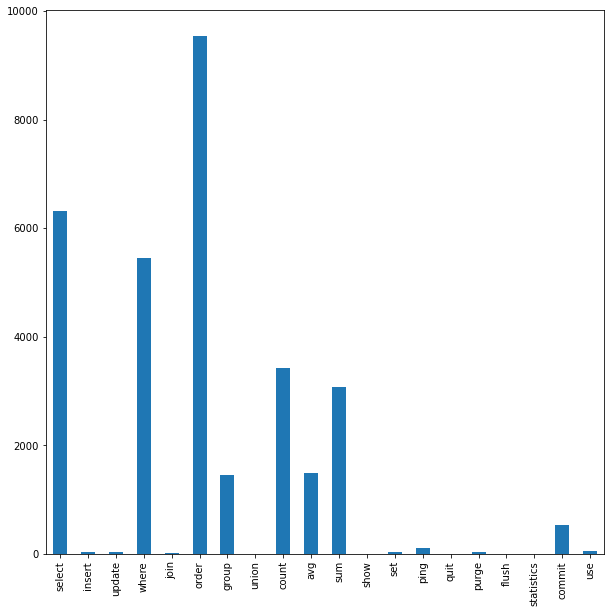

In [61]:
fig = plt.figure(figsize=(10,10))
df_slow_logs_filtered[sql_operations].sum().plot.bar()

In [62]:
df_slow_logs_op_execution = pd.DataFrame(columns=['sql_keyword','query_time'])

In [63]:
for op in sql_operations:
    df = df_slow_logs_filtered[df_slow_logs_filtered[op] > 0]
    df_slow_logs_op_execution = df_slow_logs_op_execution.append(
                                pd.DataFrame(list(zip([op for i in range(0,len(df))],list(df['query_time']))),
                                columns =['sql_keyword','query_time']))

In [64]:
df_slow_logs_op_execution = df_slow_logs_op_execution.reset_index()

In [65]:
del df_slow_logs_op_execution['index']

In [66]:
df_slow_logs_op_execution

,sql_keyword,query_time
0,select,3030934
1,select,9413563
2,select,3009603
3,select,9333081
4,select,3010968
...,...,...
16311,use,1358922
16312,use,1540125
16313,use,1519777
16314,use,454342


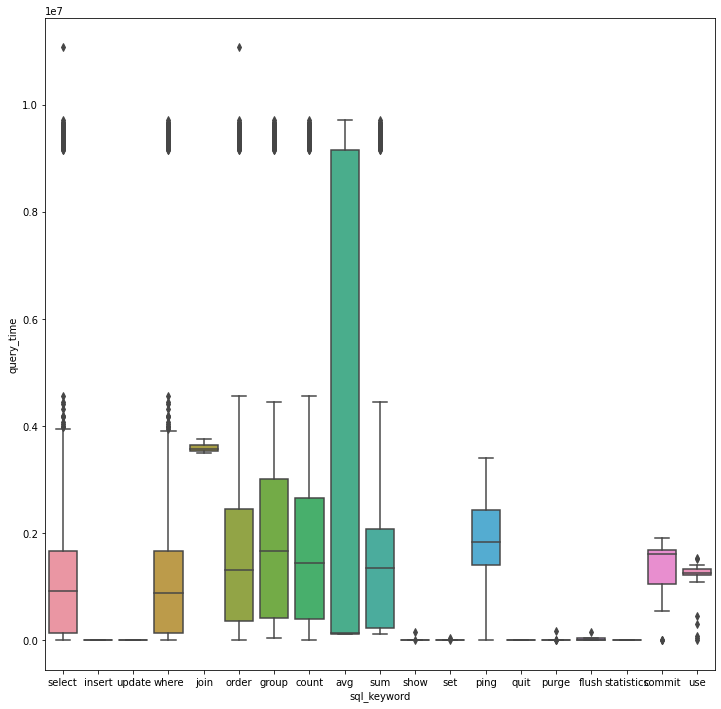

In [67]:
fig = plt.figure(figsize=(12,12))
sns.boxplot(x="sql_keyword", y="query_time", data=df_slow_logs_op_execution)

In [68]:
df_slow_logs_op_execution[df_slow_logs_op_execution['sql_keyword'] == 'avg'].sort_values(by='query_time')

,sql_keyword,query_time
13875,avg,116082
13903,avg,116185
13937,avg,116507
13805,avg,116513
13828,avg,116533
...,...,...
13697,avg,9623789
13780,avg,9625275
13733,avg,9659742
13666,avg,9682569


# Boxplot showing the distribution of the execution time for each sql keyword
## there are some notable insights:

## 1 - we saw in the distribution of the sql keywords that some of these operations are not so frequent. They also seem to have not much impact in the execution of the quey (ex: insert, update, show, set, quit, purge, flush and statistics)

## 2 - the join operations, as well known in the DB literature, have a bigger impact in the execution time (even if they are used in combination with other keywords, it is just remarkable that this behaviour can be visually seen in the plot)

## 3 - the group of outliers with execution time close to 1e7 contains most of the main sql keywords (select (obviously), where, count, ..) but surprisingly no join operation is involved

## 4 - avg keyword has a low median, meaning there are many small query execution times including avg, but also it can be found in queries with higher execution time

In [69]:
####################### TABLES ##########################

# We repeat the analysis of the keywords with the names of the tables

In [70]:
tables = ['customer','lineitem','nation','orders','part','partsupp','region','supplier']

In [71]:
for t in tables:
    df_slow_logs_filtered[t] = df_slow_logs_filtered['sql_text'].apply(lambda x: x.count(t))

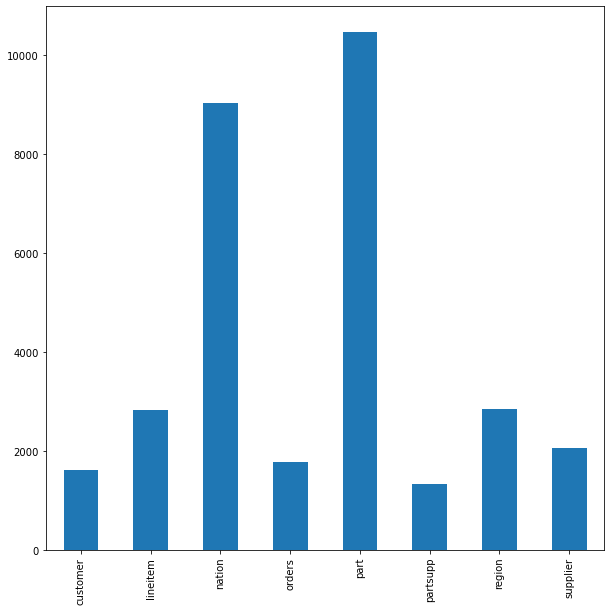

In [72]:
fig = plt.figure(figsize=(10,10))
df_slow_logs_filtered[tables].sum().plot.bar()

In [73]:
df_slow_logs_t_execution = pd.DataFrame(columns=['table','query_time'])

In [74]:
for t in tables:
    df = df_slow_logs_filtered[df_slow_logs_filtered[t] > 0]
    df_slow_logs_t_execution = df_slow_logs_t_execution.append(
                                pd.DataFrame(list(zip([t for i in range(0,len(df))],list(df['query_time']))),
                                columns =['table','query_time']))

In [75]:
df_slow_logs_t_execution

,table,query_time
0,customer,3685580
1,customer,3754431
2,customer,3669971
3,customer,3646651
4,customer,3572612
...,...,...
1408,supplier,2458301
1409,supplier,2130213
1410,supplier,3181292
1411,supplier,1813424


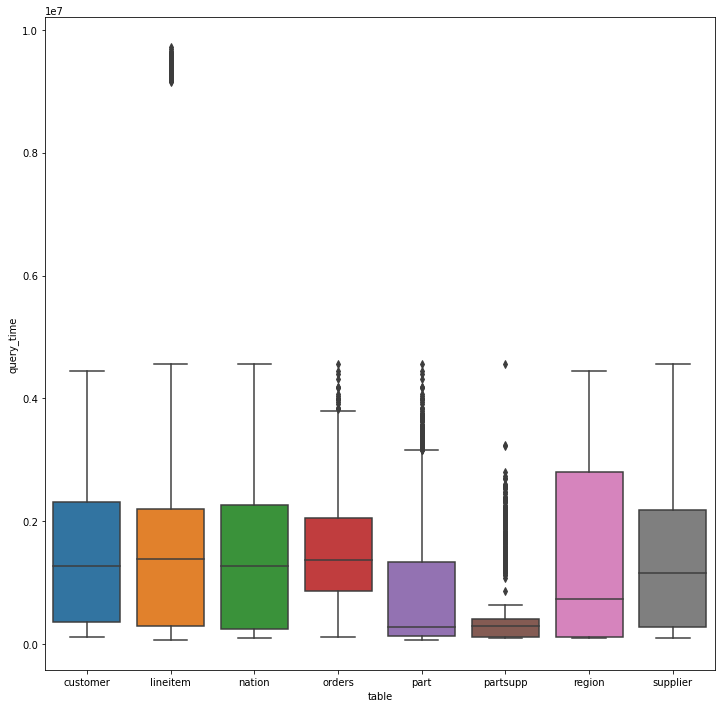

In [76]:
fig = plt.figure(figsize=(12,12))
sns.boxplot(x="table", y="query_time", data=df_slow_logs_t_execution)

## differently from slq keywords where there were some visual hints, here we can just observe that the group of outliers is all concentrated in lineitem table, but we cannot say that in general it is a slow performing table

In [77]:
## still considering the outliers we can see their query have a common pattern
len(df_slow_logs[df_slow_logs['query_time'] > 5000000])

151

In [78]:
df_slow_logs[df_slow_logs['query_time'] > 5000000][0:3]

,user_host,query_time,lock_time,rows_sent,rows_examined,db,sql_text,thread_id
515,G-185,11073425,98,77212,154424,tpch,/* applicationname=datagrip 2020.2.3 */ select * from mysql.slow_log order by start_time desc,63
2002,G-172,9513722,145,4,4423667,tpch,"-- using 1164972402 as a seed to the rng select l_returnflag, l_linestatus, sum(l_quantity) as sum_qty, sum(l_extendedprice) as sum_base_price, sum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge, avg(l_quantity) as avg_qty, avg(l_extendedprice) as avg_price, avg(l_discount) as avg_disc, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '60' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",40
2038,G-172,9528016,157,4,4423667,tpch,"-- using 377385426 as a seed to the rng select l_returnflag, l_linestatus, sum(l_quantity) as sum_qty, sum(l_extendedprice) as sum_base_price, sum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge, avg(l_quantity) as avg_qty, avg(l_extendedprice) as avg_price, avg(l_discount) as avg_disc, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval '73' day group by l_returnflag, l_linestatus order by l_returnflag, l_linestatus",40


In [79]:
pattern_outliers = "elect l_returnflag, l_linestatus, sum(l_quantity) as sum_qty, sum(l_extendedprice) as sum_base_price, sum(l_extendedprice * (1 - l_discount)) as sum_disc_price, sum(l_extendedprice * (1 - l_discount) * (1 + l_tax)) as sum_charge, avg(l_quantity) as avg_qty, avg(l_extendedprice) as avg_price, avg(l_discount) as avg_disc, count(*) as count_order from lineitem where l_shipdate <= date '1998-12-01' - interval"

In [80]:
len(df_slow_logs[df_slow_logs['sql_text'].str.find(pattern_outliers) >= 0])

150

## we can keep only one of these outliers, the one with worse performance

In [81]:
len(df_slow_logs_filtered)

3803

In [82]:
df_outliers = df_slow_logs_filtered[df_slow_logs_filtered['sql_text'].str.find(pattern_outliers) >= 0]
df_slow_logs_filtered = df_slow_logs_filtered[df_slow_logs_filtered['sql_text'].str.find(pattern_outliers) < 0]

In [83]:
len(df_slow_logs_filtered)

3653

In [84]:
len(df_outliers)

150

In [85]:
df_slow_logs_filtered = df_slow_logs_filtered.append(df_outliers.sort_values(by='query_time')[0:1])

# =============== MODEL ================== #

## considering the problem we have, it seems suitable to opt for a regression with random forests

In [86]:
# we will be using as features only the ones extracted from the query, so tables and sql_operations
X = df_slow_logs_filtered[sql_operations+tables]

In [87]:
y = df_slow_logs_filtered['query_time']

In [88]:
y

0       3030934
2       3009603
4       3010968
6       3014640
8       3020836
         ...   
3799       2734
3800       2672
3801        130
3802       1595
23      9147795
Name: query_time, Length: 3654, dtype: int64

In [89]:
from sklearn.model_selection import train_test_split

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=101)

## normalizing the data

In [91]:
from sklearn.preprocessing import MinMaxScaler

In [92]:
scaler = MinMaxScaler()

In [93]:
X_train = scaler.fit_transform(X_train)

In [94]:
X_test = scaler.transform(X_test)

In [95]:
X_train.shape

(2923, 28)

In [96]:
X_test.shape

(731, 28)

## model implementation

In [97]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)# Train the model on training data
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=1000, random_state=42)

In [98]:
import numpy as np

In [99]:
predictions = rf.predict(X_test)# Calculate the absolute errors
errors = abs(predictions - y_test)# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 136590.72 degrees.


In [100]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [101]:
mean_absolute_error(y_test,predictions)

136590.71958977575

In [102]:
np.sqrt(mean_squared_error(y_test,predictions))

282827.9401375958

In [103]:
explained_variance_score(y_test,predictions)

0.9286799409347493

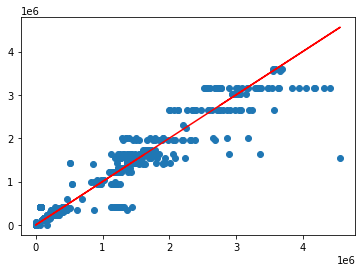

In [104]:
# Our predictions
plt.scatter(y_test,predictions)

# Perfect predictions
plt.plot(y_test,y_test,'r')

In [105]:
errors = y_test.values.reshape(731, 1) - predictions

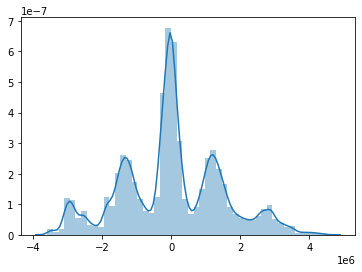

In [106]:
sns.distplot(errors)

In [107]:
import pickle

In [108]:
with open('./model/model_query_exec_prediction', 'wb') as file:  
    pickle.dump(rf, file)

In [109]:
with open('./model/scaler_query_exec_prediction', 'wb') as file:  
    pickle.dump(scaler, file)